In [1]:
import numpy as np
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from dataset import MNIST, MNISTBags
from bags import check_bag, make_bags
from utils import to_np, plot_attention
from model import MultiAttentionMIL


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
mnist = MNIST(image_file="dataset/train-images", image_label="dataset/train-labels")
images, instance_label, bag_label = make_bags(
    mnist=mnist, num_of_bags=5000, num_instances=10, label_bag=1
)
np.save("dataset/train_image.npy", images)
np.save("dataset/instance_label.npy", instance_label)
np.save("dataset/bag_label.npy", bag_label)

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

In [5]:
images = np.load("dataset/train_image.npy")
instance_label = np.load("dataset/instance_label.npy")
bag_label = np.load("dataset/bag_label.npy")


dset = MNISTBags(bags=images, label=bag_label)
dloader = DataLoader(dataset=dset, batch_size=1, shuffle=True)

epochs = 20

model = MultiAttentionMIL(
    num_classes=2, num_features=28 * 28, use_dropout=True, n_dropout=0.5
)

optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.999))
criterion = torch.nn.CrossEntropyLoss()
model.to(device)

for e in range(epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    best_acc = 0
    pbar_loader = tqdm(dloader)
    counter = 1
    for data, label in pbar_loader:
        optimizer.zero_grad()
        label = label[0]
        data, label = data.to(device), label.to(device)
        output, a1, a2, a3 = model(data)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()        
        predicted = torch.argmax(nn.Softmax(dim=1)(output))

        if predicted == int(label.item()):
            correct += 1

        counter += 1
        if counter % 20 == 0:
            pbar_loader.set_description(f"running loss: {loss:.3f}")

    acc = correct / len(dloader)
    if acc > best_acc:
        torch.save(model.state_dict(), "saved_data/best.pkl")
    print(f"epoch:{e+1}   loss: {train_loss/len(dloader):.3f}   accuracy: {acc:.3f} \n")

  0%|          | 0/5000 [00:00<?, ?it/s]

epoch:1   loss: 0.208   accuracy: 0.911 



  0%|          | 0/5000 [00:00<?, ?it/s]

epoch:2   loss: 0.087   accuracy: 0.971 



  0%|          | 0/5000 [00:00<?, ?it/s]

epoch:3   loss: 0.068   accuracy: 0.979 



  0%|          | 0/5000 [00:00<?, ?it/s]

epoch:4   loss: 0.057   accuracy: 0.983 



  0%|          | 0/5000 [00:00<?, ?it/s]

epoch:5   loss: 0.053   accuracy: 0.986 



  0%|          | 0/5000 [00:00<?, ?it/s]

epoch:6   loss: 0.051   accuracy: 0.985 



  0%|          | 0/5000 [00:00<?, ?it/s]

epoch:7   loss: 0.044   accuracy: 0.987 



  0%|          | 0/5000 [00:00<?, ?it/s]

epoch:8   loss: 0.038   accuracy: 0.989 



  0%|          | 0/5000 [00:00<?, ?it/s]

epoch:9   loss: 0.038   accuracy: 0.988 



  0%|          | 0/5000 [00:00<?, ?it/s]

epoch:10   loss: 0.033   accuracy: 0.990 



  0%|          | 0/5000 [00:00<?, ?it/s]

epoch:11   loss: 0.031   accuracy: 0.989 



  0%|          | 0/5000 [00:00<?, ?it/s]

epoch:12   loss: 0.030   accuracy: 0.991 



  0%|          | 0/5000 [00:00<?, ?it/s]

epoch:13   loss: 0.031   accuracy: 0.990 



  0%|          | 0/5000 [00:00<?, ?it/s]

epoch:14   loss: 0.027   accuracy: 0.991 



  0%|          | 0/5000 [00:00<?, ?it/s]

epoch:15   loss: 0.026   accuracy: 0.991 



  0%|          | 0/5000 [00:00<?, ?it/s]

epoch:16   loss: 0.023   accuracy: 0.992 



  0%|          | 0/5000 [00:00<?, ?it/s]

epoch:17   loss: 0.022   accuracy: 0.992 



  0%|          | 0/5000 [00:00<?, ?it/s]

epoch:18   loss: 0.019   accuracy: 0.993 



  0%|          | 0/5000 [00:00<?, ?it/s]

epoch:19   loss: 0.020   accuracy: 0.994 



  0%|          | 0/5000 [00:00<?, ?it/s]

epoch:20   loss: 0.017   accuracy: 0.994 



In [ ]:
mnist = MNIST(
    image_file="dataset/test-images",
    image_label="dataset/test-labels",
    train=False,
)
images, instance_label, bag_label = make_bags(
    mnist=mnist, num_of_bags=200, num_instances=10, label_bag=1
)
dset = MNISTBags(bags=images, label=bag_label)
dloader = DataLoader(dataset=dset, batch_size=1, shuffle=False)
dct_res = {}

model = MultiAttentionMIL(
    num_classes=2, num_features=28 * 28, use_dropout=True, n_dropout=0.5
)
model.load_state_dict(torch.load("saved_data/best.pkl"))
model.to(device)
model.eval()
with torch.no_grad():
    tq_loader = tqdm(dloader)
    for i, (data, label) in enumerate(tq_loader):
        # print(data.size())
        label = label[0]
        data, label = data.to(device), label.to(device)

        output, a1, a2, a3 = model(data)
        predicted = torch.argmax(nn.Softmax(dim=1)(output))
        dct_res[i] = {}
        dct_res[i]["label_true"] = label.cpu().numpy()[0]
        dct_res[i]["label_pred"] = predicted.cpu().numpy()
        dct_res[i]["data"] = np.squeeze(data.cpu().numpy())
        dct_res[i]["instance_label"] = instance_label[i]
        dct_res[i]["att_score1"] = torch.squeeze(a1).cpu().numpy()
        dct_res[i]["att_score2"] = torch.squeeze(a2).cpu().numpy()
        dct_res[i]["att_score3"] = torch.squeeze(a3).cpu().numpy()

        tq_loader.set_description("predicting on test set")

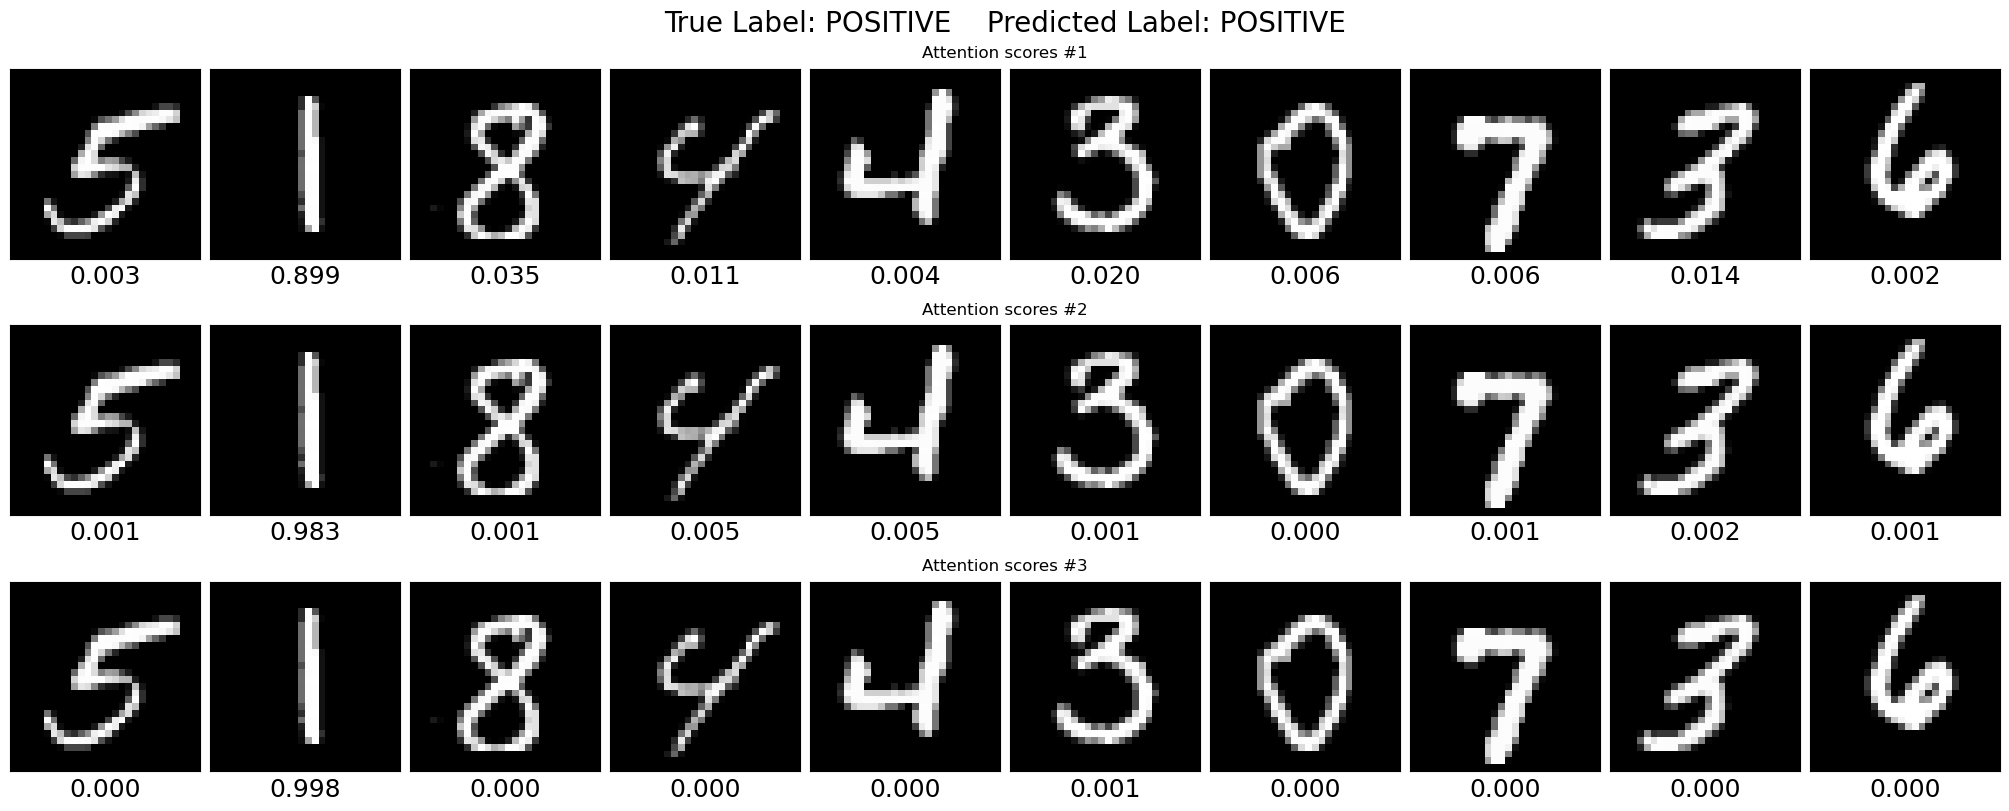

In [5]:
plot_attention(dct_result=dct_res, idx_dct=13, fname="attention_visualisation_truepos")

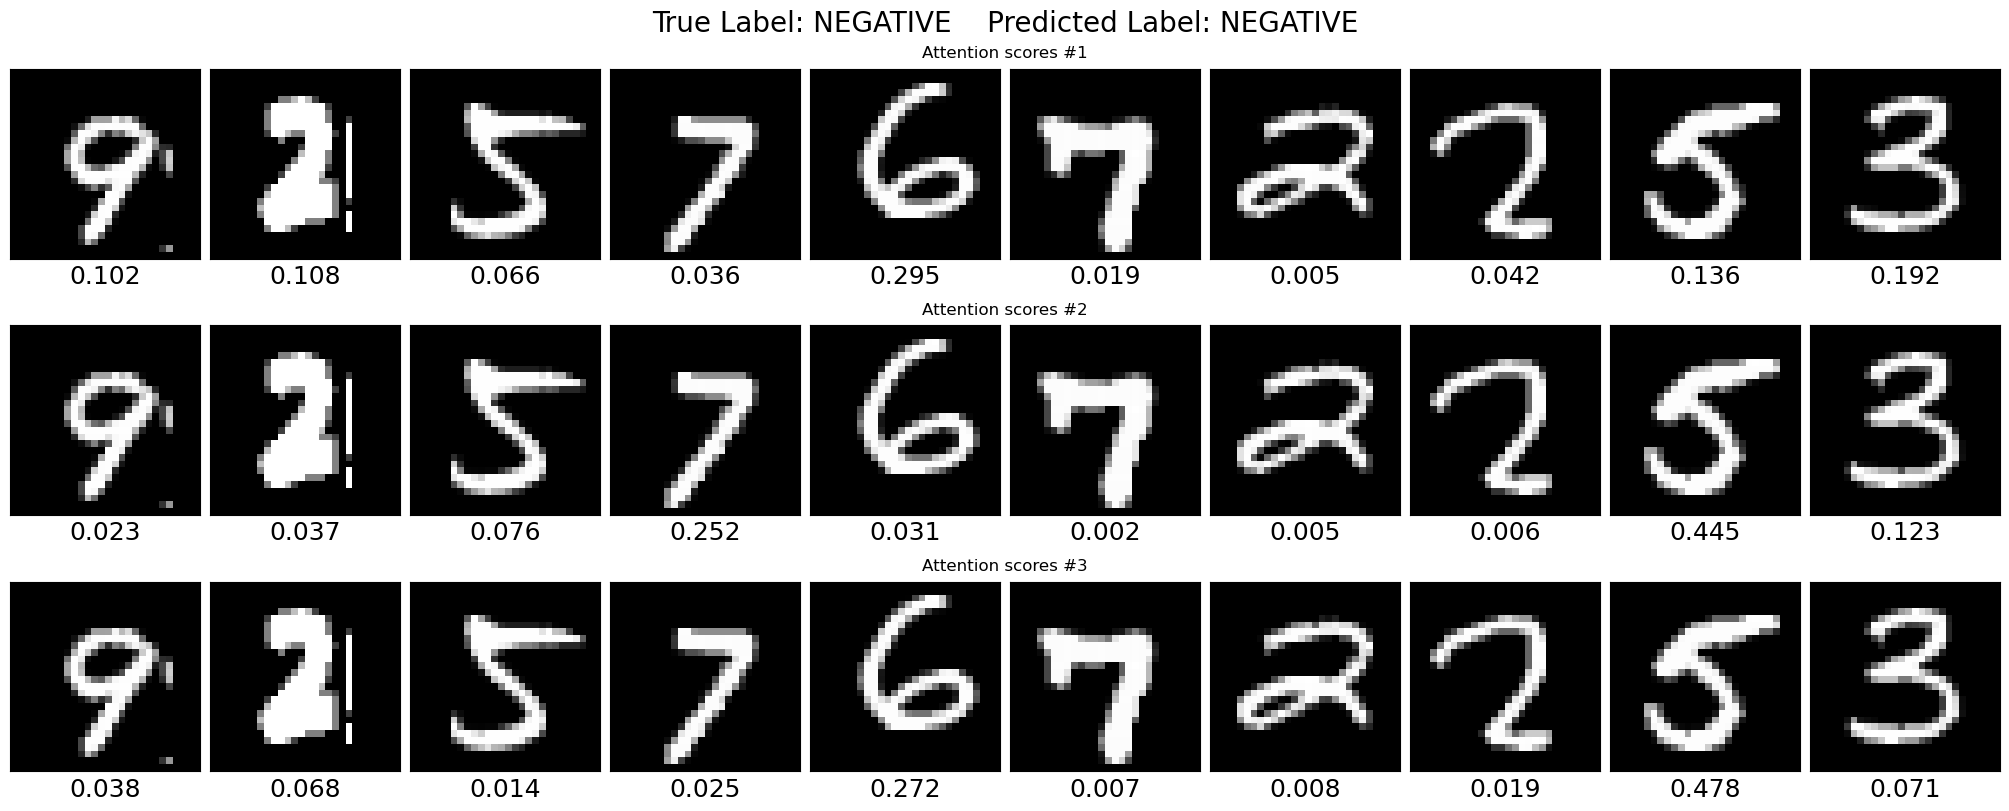

In [6]:
plot_attention(dct_result=dct_res, idx_dct=101, fname="attention_visualisation_trueneg")